# GAN Experiment

Here is my reference for [Pokemon GAN experiment](https://medium.com/@jkleiber8/pokegan-generating-fake-pokemon-with-a-generative-adversarial-network-f540db81548d), which was very helpful for setting up this project.

In [3]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
torch.cuda.is_available()


True

In [4]:
def image_dataset_cleaner(dataset_path):
    """
    Removes images that cannot be read by cv2
    """
    import PIL as pil 
    for image in os.listdir(dataset_path):
        img = cv2.imread(os.path.join(dataset_path, image))
        if img is None:
            os.remove(os.path.join(dataset_path, image))
    return 

epoch

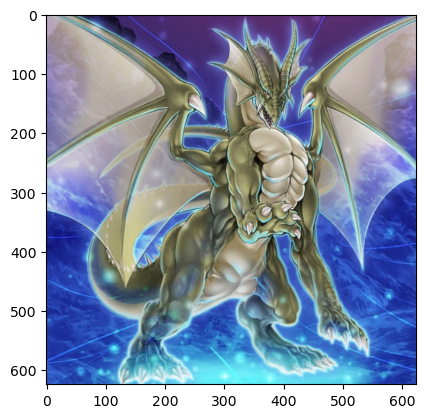

In [10]:
dataset_path = "training_magician/darkmagician"
image_name = "3078380.jpg"
img = cv2.imread(os.path.join(dataset_path, image_name))
# show the image
plt.imshow(img)

In [11]:
dataset_path = "training_magician/darkmagician"
print("The dataset before cleaning has " , len(os.listdir(dataset_path)))
image_dataset_cleaner(dataset_path)
print("The dataset after cleaning has " , len(os.listdir(dataset_path)))
IMAGE_COUNT = len(os.listdir(dataset_path))

The dataset before cleaning has  167
The dataset after cleaning has  167


In [ ]:
dataset_path = "training_magician/darkmagician"
print("The dataset before cleaning has " , len(os.listdir(dataset_path)))
image_dataset_cleaner(dataset_path)
print("The dataset after cleaning has " , len(os.listdir(dataset_path)))
IMAGE_COUNT = len(os.listdir(dataset_path))

In [12]:
dataset_path = "training_magician"

for arch in os.listdir(dataset_path):

    full_path = os.path.join(dataset_path, arch)
    print("The " +  arch + " dataset before cleaning has " , len(os.listdir(full_path)))
    image_dataset_cleaner(full_path)
    print("The " +  arch + " dataset after cleaning has " , len(os.listdir(full_path)))

The darkmagician dataset before cleaning has  167
The darkmagician dataset after cleaning has  167


### Testing my dataset, checking file integrity

In [13]:
image_name = "3078380.jpg"
os.path.join(dataset_path, image_name)

'training_magician/3078380.jpg'

In [14]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [15]:
IMAGE_DIR = "training_magician"
image_size = 64
batch_size = 8
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from [0, 1] to [-1, 1]

In [16]:
normal_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with mirrored images
mirror_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with color changes
color_jitter_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Combine the datasets
dataset_list = [normal_dataset, mirror_dataset, color_jitter_dataset]

AUGMENTATION_RANGE = 0
dataset_list_full = []
for i in range(AUGMENTATION_RANGE):
    # normal_dataset
    dataset_list_full += dataset_list
    # dataset_list_full += [normal_dataset]

if len(dataset_list_full)==0:
    dataset_list_full = dataset_list

dataset = ConcatDataset(dataset_list_full)

dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

print("The estimated number of images is ", IMAGE_COUNT * AUGMENTATION_RANGE * 3)


The estimated number of images is  0


Since these images have been normalized to [-1, 1],  we need to denormalize them in order to view them. Below is a denormalization function to do just that.

In [17]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

Now let's show a sample batch of real Pokemon images

In [18]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

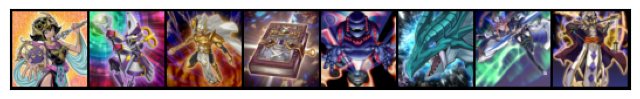

In [20]:
show_batch(dataloader)

Now that we know the visualization works, we can continue with making the GAN. First, we'll start with the discriminator

# Discriminator Models

Below I make a few possible discriminator models to try out

In [21]:
import torch.nn as nn

This is my first effort at making a discriminator for this dataset

In [22]:
disc_1 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 16 x 128 x 128
    
    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 32 x 64 x 64
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [23]:
disc_2 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
disc_2.fc.out_features = 1
disc_2

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_v0.6.0
/opt/conda/envs/ygo/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/ygo/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Same as Discriminator 1, but with smaller kernel size
disc_3 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 16, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 16 x 128 x 128
    
    nn.Conv2d(16, 32, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 32 x 64 x 64
    
    nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 4 x 4
    
    # Additional layer to make it 2x2
    nn.Conv2d(512, 1024, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 2 x 2
    
    # With a 2x2, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(1024, 1, kernel_size=2, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [25]:
disc_5 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 64 x 128 x 128
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 128 x 64 x 64
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 32 x 32
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 16 x 16
    
    nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [26]:
disc_64_1 = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 32 x 32 x 32
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 16 x 16
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 256 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [27]:
disc_64_2 = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

# Generator Models

Below is a list of some possible generator models to try. These models are inverse operations of the discriminators.

Here's the first generator:

In [28]:
seed_size = 16

In [29]:
gen_1 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 512, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 64 x 64
    
    nn.ConvTranspose2d(32, 16, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # Layer output: 16 x 128 x 128
    
    nn.ConvTranspose2d(16, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [30]:
# Generator matching Discriminator 3
gen_3 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 1024, kernel_size=2, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # Layer output: 1024 x 2 x 2
    
    nn.ConvTranspose2d(1024, 512, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 64 x 64
    
    nn.ConvTranspose2d(32, 16, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # Layer output: 16 x 128 x 128
    
    nn.ConvTranspose2d(16, 3, kernel_size=2, padding=0, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [31]:
# Generator with lots of upsampling weirdness
gen_4 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 1024, kernel_size=2, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # Layer output: 1024 x 2 x 2
    
    nn.ConvTranspose2d(1024, 512, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1, stride=9, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 64 x 64
    
    nn.ConvTranspose2d(128, 3, kernel_size=4, padding=0, stride=4, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [32]:
gen_5 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 256, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(256, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 16 x 16
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 32 x 32
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 128 x 64 x 64
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 64 x 128 x 128
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [33]:
gen_64_1 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 256, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 64 x 64
)

In [34]:
gen_64_2 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 64 x 64
)

# Model Testing

This is to make sure everything is the correct size

In [35]:
test_model_size = False

if test_model_size:
    # Make some latent tensors to seed the generator
    seed_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)

    # Get some fake pokemon
    generator=gen_64_1
    to_device(generator, device)
    fake_pokemon = generator(seed_batch)
    print(fake_pokemon.size())

# GPU Setup
We should train this on a GPU, so I'll set that up right now

In [36]:
def get_training_device():
    # Use the GPU if possible
    if torch.cuda.is_available():
        return torch.device('cuda')
    # Otherwise use the CPU :-(
    return torch.device('cpu')

def to_device(data, device):
    # This moves the tensors to the device (GPU, CPU)
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [37]:
device = get_training_device()
device

device(type='cuda')

If the above output doesn't say something about 'cuda', then make sure the notebook is set up to run on the GPU accelerator.  

Now, we use the device dataloader class to send data to our chosen device:

In [38]:
# Using the dataloader from the top of the notebook, and the selected device
# create a device data loader
dev_dataloader = DeviceDataLoader(dataloader, device)

# **Training Functions**

## Discriminator

In [39]:
def train_discriminator(real_pokemon, disc_optimizer):
    # Reset the gradients for the optimizer
    disc_optimizer.zero_grad()
    
    # Train on the real images
    real_predictions = discriminator(real_pokemon)
    # real_targets = torch.zeros(real_pokemon.size(0), 1, device=device) # All of these are real, so the target is 0.
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0 # Add some noisy labels to make the discriminator think harder.
    real_loss = F.binary_cross_entropy(real_predictions, real_targets) # Can do binary loss function because it is a binary classifier
    real_score = torch.mean(real_predictions).item() # How well does the discriminator classify the real pokemon? (Higher score is better for the discriminator)
    
    # Make some latent tensors to seed the generator
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    
    # Get some fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Train on the generator's current efforts to trick the discriminator
    gen_predictions = discriminator(fake_pokemon)
    # gen_targets = torch.ones(fake_pokemon.size(0), 1, device=device)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9 # Add some noisy labels to make the discriminator think harder.
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item() # How well did the discriminator classify the fake pokemon? (Lower score is better for the discriminator)
    
    # Update the discriminator weights
    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    return total_loss.item(), real_score, gen_score

## Generator

In [40]:
def train_generator(gen_optimizer):
    # Clear the generator gradients
    gen_optimizer.zero_grad()
    
    # Generate some fake pokemon
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)
    
    # Test against the discriminator
    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device) # We want the discriminator to think these images are real.
    loss = F.binary_cross_entropy(disc_predictions, targets) # How well did the generator do? (How much did the discriminator believe the generator?)
    
    # Update the generator based on how well it fooled the discriminator
    loss.backward()
    gen_optimizer.step()
    
    # Return generator loss
    return loss.item()

## Results Viewer
We want to be able to see the results as we generate pokemon

In [41]:
import os
from torchvision.utils import save_image

RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [42]:
def save_results(index, latent_batch, show=True):
    # Generate fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Make the filename for the output
    fake_file = "result-image-{0:0=4d}.png".format(index)
    
    # Save the image
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Result Saved!")
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

In [43]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
torch.cuda.is_available()


True

# **Full Training**

In [44]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Static generation seed batch
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    # Empty the GPU cache to save some memory
    torch.cuda.empty_cache()
    
    # Track losses and scores
    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    # Create the optimizers
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    # Run the loop
    for epoch in range(epochs):
        # Go through each image
        for real_img, _ in tqdm(dev_dataloader):
            # Train the discriminator
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)

            # Train the generator
            gen_loss = train_generator(gen_optimizer)
        
        # Collect results
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        
        # Print the losses and scores
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        # Save the images and show the progress
        save_results(epoch + start_idx, fixed_latent_batch, show=False)
    
    # Return stats
    return disc_losses, disc_scores, gen_losses, gen_scores

# GPU Clean-up
Sometimes the Kaggle GPU runs out of memory. This block frees up the GPU and resends the device dataloader to the GPU

In [45]:
device = get_training_device()
device

device(type='cuda')

In [46]:
def debug_memory():
    import collections, gc, resource, torch
    print('maxrss = {}'.format(
        resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
    tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
                                  for o in gc.get_objects()
                                  if torch.is_tensor(o))
    for line in tensors.items():
        print('{}\t{}'.format(*line))

In [47]:
mem_debug = False
if mem_debug:
    debug_memory()

In [48]:
# Clean up everything
cleanup = False
if cleanup:
    import gc
    del dev_dataloader
    del discriminator
    del generator
    dev_dataloader = None
    discriminator = None
    generator = None
    gc.collect()
    torch.cuda.empty_cache()

In [49]:
# Re-initialize the device dataloader
dev_dataloader = DeviceDataLoader(dataloader, device)

# Selecting Models
Here, I select the models I want to send to the GPU

In [50]:
# Discriminators
# discriminator = disc_1
# discriminator = disc_2
# discriminator = disc_3
# discriminator = disc_5

# 64 x 64 Discriminators
# discriminator = disc_64_1
discriminator = disc_64_2

# Send to device
discriminator = to_device(discriminator, device)

In [51]:
# Generators
# generator = gen_1
# generator = gen_3
# generator = gen_5

# 64 x 64 Generators
# generator = gen_64_1
generator = gen_64_2

# Send to device
generator = to_device(generator, device)

# Training Time
Here I'll edit hyperparameters and train the GAN

In [52]:
# learning_rate = 0.0025 # worked fairly well for disc/gen_64_1
learning_rate = 0.00275
epochs = 100

In [53]:
history = train(epochs, learning_rate)

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [1/100], gen_loss: 2.9828, disc_loss: 0.8227, real_score: 0.0085, gen_score: 0.5769
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [2/100], gen_loss: 3.0831, disc_loss: 0.3684, real_score: 0.0599, gen_score: 0.9638
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [3/100], gen_loss: 2.0995, disc_loss: 0.4616, real_score: 0.1356, gen_score: 0.9517
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [4/100], gen_loss: 1.9722, disc_loss: 1.8174, real_score: 0.7574, gen_score: 0.9792
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [5/100], gen_loss: 3.0160, disc_loss: 3.1872, real_score: 0.0686, gen_score: 0.0634
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [6/100], gen_loss: 2.5052, disc_loss: 0.5428, real_score: 0.1492, gen_score: 0.9357
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [7/100], gen_loss: 3.4178, disc_loss: 0.4933, real_score: 0.0390, gen_score: 0.8771
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [8/100], gen_loss: 2.9652, disc_loss: 0.6821, real_score: 0.2748, gen_score: 0.9088
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [9/100], gen_loss: 1.8547, disc_loss: 0.6762, real_score: 0.3012, gen_score: 0.9091
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [10/100], gen_loss: 2.6270, disc_loss: 0.8135, real_score: 0.0793, gen_score: 0.6220
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [11/100], gen_loss: 0.7308, disc_loss: 1.4940, real_score: 0.6907, gen_score: 0.8740
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [12/100], gen_loss: 1.5782, disc_loss: 0.9321, real_score: 0.3629, gen_score: 0.7856
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [13/100], gen_loss: 3.3150, disc_loss: 1.9616, real_score: 0.0645, gen_score: 0.2341
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [14/100], gen_loss: 2.9663, disc_loss: 0.8169, real_score: 0.0258, gen_score: 0.6690
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [15/100], gen_loss: 4.8316, disc_loss: 0.8311, real_score: 0.1213, gen_score: 0.6758
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [16/100], gen_loss: 1.8285, disc_loss: 0.6114, real_score: 0.2101, gen_score: 0.8153
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [17/100], gen_loss: 3.4215, disc_loss: 0.4721, real_score: 0.1116, gen_score: 0.9747
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [18/100], gen_loss: 3.0705, disc_loss: 0.5414, real_score: 0.1227, gen_score: 0.8260
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [19/100], gen_loss: 1.9068, disc_loss: 0.7802, real_score: 0.3319, gen_score: 0.8964
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [20/100], gen_loss: 1.6481, disc_loss: 0.8577, real_score: 0.3785, gen_score: 0.9700
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [21/100], gen_loss: 4.3087, disc_loss: 0.5161, real_score: 0.1416, gen_score: 0.9388
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [22/100], gen_loss: 5.0952, disc_loss: 0.7173, real_score: 0.0475, gen_score: 0.7190
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [23/100], gen_loss: 1.8360, disc_loss: 0.6212, real_score: 0.2601, gen_score: 0.9227
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [24/100], gen_loss: 1.7281, disc_loss: 1.4851, real_score: 0.3021, gen_score: 0.4774
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [25/100], gen_loss: 3.0357, disc_loss: 0.6713, real_score: 0.1280, gen_score: 0.7403
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [26/100], gen_loss: 2.8232, disc_loss: 0.9738, real_score: 0.1642, gen_score: 0.6546
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [27/100], gen_loss: 1.7481, disc_loss: 2.1592, real_score: 0.8114, gen_score: 0.8634
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [28/100], gen_loss: 3.8715, disc_loss: 0.8878, real_score: 0.0483, gen_score: 0.6112
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [29/100], gen_loss: 4.0635, disc_loss: 0.6064, real_score: 0.0728, gen_score: 0.8063
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [30/100], gen_loss: 4.6768, disc_loss: 0.7068, real_score: 0.1850, gen_score: 0.7642
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [31/100], gen_loss: 1.2749, disc_loss: 0.5896, real_score: 0.1965, gen_score: 0.8415
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [32/100], gen_loss: 3.1933, disc_loss: 0.8318, real_score: 0.3062, gen_score: 0.8956
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [33/100], gen_loss: 4.1050, disc_loss: 0.7112, real_score: 0.0971, gen_score: 0.7095
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [34/100], gen_loss: 3.3775, disc_loss: 1.0731, real_score: 0.2477, gen_score: 0.7276
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [35/100], gen_loss: 2.1777, disc_loss: 0.7559, real_score: 0.2418, gen_score: 0.7706
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [36/100], gen_loss: 4.8715, disc_loss: 0.9427, real_score: 0.0313, gen_score: 0.6075
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [37/100], gen_loss: 3.3206, disc_loss: 0.5932, real_score: 0.1099, gen_score: 0.7919
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [38/100], gen_loss: 2.4284, disc_loss: 1.0417, real_score: 0.3770, gen_score: 0.7497
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [39/100], gen_loss: 4.2342, disc_loss: 0.7367, real_score: 0.0236, gen_score: 0.6723
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [40/100], gen_loss: 3.7740, disc_loss: 0.8298, real_score: 0.1567, gen_score: 0.6331
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [41/100], gen_loss: 2.7017, disc_loss: 0.5354, real_score: 0.1354, gen_score: 0.8770
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [42/100], gen_loss: 2.9827, disc_loss: 1.0102, real_score: 0.2000, gen_score: 0.7483
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [43/100], gen_loss: 3.2812, disc_loss: 0.7599, real_score: 0.2177, gen_score: 0.7541
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [44/100], gen_loss: 4.3198, disc_loss: 0.6915, real_score: 0.0401, gen_score: 0.7696
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [45/100], gen_loss: 2.4163, disc_loss: 0.5845, real_score: 0.2693, gen_score: 0.9439
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [46/100], gen_loss: 2.4837, disc_loss: 0.4734, real_score: 0.0778, gen_score: 0.8018
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [47/100], gen_loss: 4.3454, disc_loss: 0.4740, real_score: 0.0698, gen_score: 0.9783
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [48/100], gen_loss: 5.8181, disc_loss: 0.5714, real_score: 0.0939, gen_score: 0.7467
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [49/100], gen_loss: 5.1174, disc_loss: 0.4558, real_score: 0.0875, gen_score: 0.8790
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [50/100], gen_loss: 4.4262, disc_loss: 0.9167, real_score: 0.0391, gen_score: 0.5911
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [51/100], gen_loss: 3.5580, disc_loss: 0.5429, real_score: 0.1211, gen_score: 0.8871
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [52/100], gen_loss: 3.1275, disc_loss: 0.5593, real_score: 0.0137, gen_score: 0.7458
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [53/100], gen_loss: 4.7983, disc_loss: 0.5406, real_score: 0.1637, gen_score: 0.9872
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [54/100], gen_loss: 2.6320, disc_loss: 0.7977, real_score: 0.1878, gen_score: 0.7018
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [55/100], gen_loss: 2.5361, disc_loss: 1.3764, real_score: 0.5502, gen_score: 0.9383
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [56/100], gen_loss: 3.6129, disc_loss: 0.4147, real_score: 0.1236, gen_score: 0.9604
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [57/100], gen_loss: 3.4203, disc_loss: 0.7118, real_score: 0.2746, gen_score: 0.9073
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [58/100], gen_loss: 5.0927, disc_loss: 0.9140, real_score: 0.0141, gen_score: 0.6058
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [59/100], gen_loss: 5.9681, disc_loss: 0.9050, real_score: 0.0717, gen_score: 0.5886
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [60/100], gen_loss: 4.5454, disc_loss: 0.6857, real_score: 0.1484, gen_score: 0.7527
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [61/100], gen_loss: 2.8225, disc_loss: 1.1708, real_score: 0.3730, gen_score: 0.9772
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [62/100], gen_loss: 3.7239, disc_loss: 0.6758, real_score: 0.2921, gen_score: 0.8798
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [63/100], gen_loss: 5.7494, disc_loss: 0.8333, real_score: 0.0185, gen_score: 0.6805
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [64/100], gen_loss: 3.6093, disc_loss: 0.5333, real_score: 0.0721, gen_score: 0.8444
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [65/100], gen_loss: 2.2286, disc_loss: 0.8160, real_score: 0.3641, gen_score: 0.8829
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [66/100], gen_loss: 2.8373, disc_loss: 0.5256, real_score: 0.0247, gen_score: 0.9469
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [67/100], gen_loss: 4.2488, disc_loss: 0.6673, real_score: 0.0646, gen_score: 0.7018
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [68/100], gen_loss: 5.7622, disc_loss: 0.5099, real_score: 0.1271, gen_score: 0.9726
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [69/100], gen_loss: 2.0085, disc_loss: 1.2558, real_score: 0.5522, gen_score: 0.8866
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [70/100], gen_loss: 3.7791, disc_loss: 0.4698, real_score: 0.0737, gen_score: 0.9112
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [71/100], gen_loss: 5.4880, disc_loss: 0.7200, real_score: 0.0780, gen_score: 0.7498
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [72/100], gen_loss: 4.5208, disc_loss: 0.4441, real_score: 0.0751, gen_score: 0.9822
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [73/100], gen_loss: 5.3926, disc_loss: 0.4305, real_score: 0.1382, gen_score: 0.9748
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [74/100], gen_loss: 5.7029, disc_loss: 0.4383, real_score: 0.0241, gen_score: 0.9813
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [75/100], gen_loss: 2.9586, disc_loss: 0.8135, real_score: 0.2909, gen_score: 0.9028
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [76/100], gen_loss: 4.3932, disc_loss: 0.4920, real_score: 0.1071, gen_score: 0.9761
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [77/100], gen_loss: 6.1990, disc_loss: 0.6552, real_score: 0.1775, gen_score: 0.9424
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [78/100], gen_loss: 2.7416, disc_loss: 0.9055, real_score: 0.4390, gen_score: 0.8449
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [79/100], gen_loss: 5.3998, disc_loss: 0.5913, real_score: 0.0805, gen_score: 0.7798
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [80/100], gen_loss: 2.5861, disc_loss: 0.5720, real_score: 0.2326, gen_score: 0.8981
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [81/100], gen_loss: 3.8274, disc_loss: 1.0671, real_score: 0.4320, gen_score: 0.9933
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [82/100], gen_loss: 1.9211, disc_loss: 0.4470, real_score: 0.0888, gen_score: 0.8674
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [83/100], gen_loss: 3.9503, disc_loss: 0.5955, real_score: 0.1488, gen_score: 0.8995
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [84/100], gen_loss: 3.6930, disc_loss: 0.7109, real_score: 0.1921, gen_score: 0.9036
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [85/100], gen_loss: 3.0751, disc_loss: 0.5639, real_score: 0.1176, gen_score: 0.8869
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [86/100], gen_loss: 8.2713, disc_loss: 0.7139, real_score: 0.2025, gen_score: 0.9985
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [87/100], gen_loss: 3.9384, disc_loss: 0.5244, real_score: 0.1567, gen_score: 0.9734
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [88/100], gen_loss: 2.9207, disc_loss: 0.5818, real_score: 0.1710, gen_score: 0.9540
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [89/100], gen_loss: 2.7883, disc_loss: 0.4027, real_score: 0.1299, gen_score: 0.9674
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [90/100], gen_loss: 3.8727, disc_loss: 1.3856, real_score: 0.3242, gen_score: 0.6617
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [91/100], gen_loss: 5.2568, disc_loss: 0.7111, real_score: 0.0340, gen_score: 0.7552
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [92/100], gen_loss: 2.5580, disc_loss: 0.6059, real_score: 0.2775, gen_score: 0.9654
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [93/100], gen_loss: 4.7736, disc_loss: 0.4354, real_score: 0.0413, gen_score: 0.9819
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [94/100], gen_loss: 5.4497, disc_loss: 0.5259, real_score: 0.1386, gen_score: 0.9383
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [95/100], gen_loss: 5.1207, disc_loss: 0.9888, real_score: 0.0198, gen_score: 0.5621
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [96/100], gen_loss: 4.8533, disc_loss: 0.4952, real_score: 0.0384, gen_score: 0.9296
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [97/100], gen_loss: 2.2503, disc_loss: 1.1136, real_score: 0.4452, gen_score: 0.9036
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [98/100], gen_loss: 2.8718, disc_loss: 0.4464, real_score: 0.0757, gen_score: 0.8678
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [99/100], gen_loss: 5.1577, disc_loss: 0.5346, real_score: 0.1434, gen_score: 0.9663
Result Saved!


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [100/100], gen_loss: 2.3661, disc_loss: 0.4585, real_score: 0.0610, gen_score: 0.9186
Result Saved!


# View Results
Here, we will view the results for the PokeGAN using IPython's Image class

In [54]:
from IPython.display import Image

There are some blobs appearing at 10 epochs

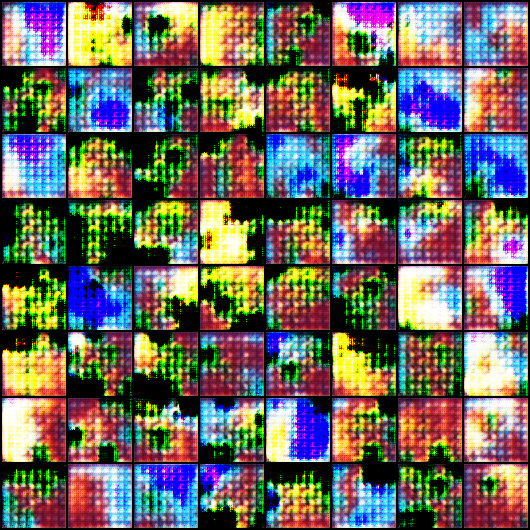

In [55]:
Image('./results/result-image-0010.png')

At 25 epochs the fake pokemon have more defined shapes:

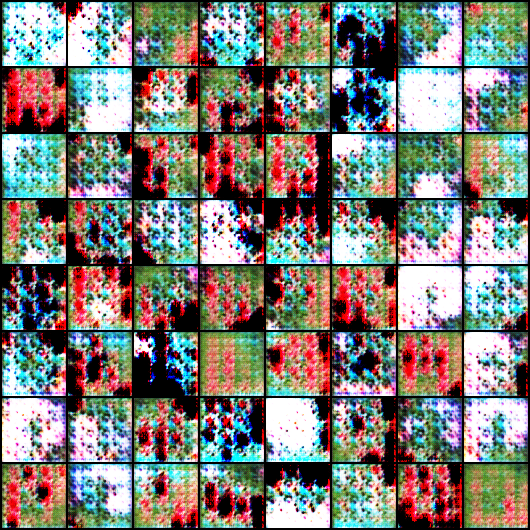

In [56]:
Image('./results/result-image-0025.png')

And by 50 epochs, more distinct features start appearing:

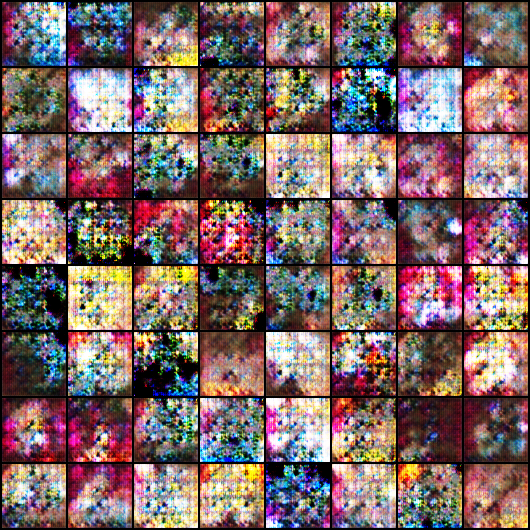

In [57]:
Image('./results/result-image-0050.png')

# Performance Analysis

Here are some plots to help tune the generator/discriminator. This shows losses and scores over time.

In [58]:
# Extract metrics
disc_losses, disc_scores, gen_losses, gen_scores = history

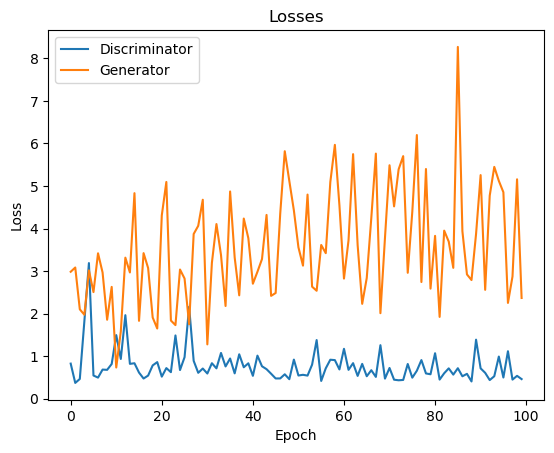

In [59]:
# Plot generator and discriminator losses
plt.plot(disc_losses, '-')
plt.plot(gen_losses, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

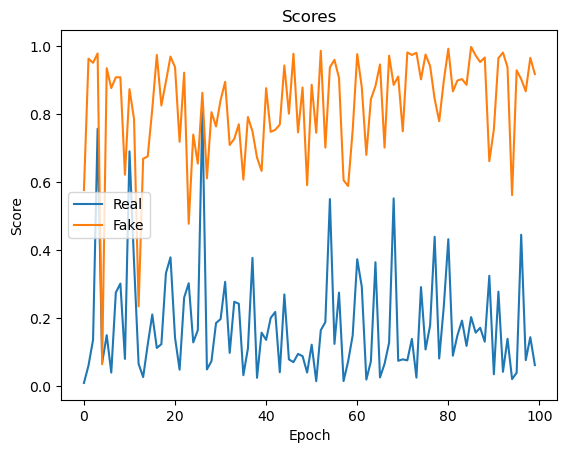

In [60]:
# Plots scores vs. epochs
plt.plot(disc_scores, '-')
plt.plot(gen_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

# Exporting Data
If the model works well, it definitely should be saved for later! Here I will export the weights for both the discriminator and generator, as well as send the notebook to Jovian.ml

In [61]:
# Save generator and discriminator weights
torch.save(discriminator.state_dict(), 'discriminator-model.pth')
torch.save(generator.state_dict(), 'generator-model.pth')

In [62]:
# example of calculating the frechet inception distance in Keras
import numpy
import os
os.environ["KERAS_BACKEND"] = "torch"
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
FID (same): -0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
FID (different): 37.429


In [99]:
my_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

fake_ygo = generator(my_latent_batch)
index = 100
# Make the filename for the output
fake_file = "MY___result-image-{0:0=4d}.png".format(index)

# Save the image
save_image(denorm(fake_ygo), os.path.join(RESULTS_DIR, fake_file), nrow=8)

In [64]:
len(fake_ygo)

64

In [100]:
case_study = fake_ygo[0]
my_fake = "my_fake_image_01.png"
save_image(denorm(case_study), os.path.join(RESULTS_DIR, my_fake))

In [66]:
case_study

tensor([[[ 0.0532,  0.1933,  0.1635,  ...,  0.0153, -0.0264,  0.1687],
         [ 0.1801,  0.1498,  0.3441,  ..., -0.0288,  0.1514,  0.2188],
         [ 0.2698,  0.3878,  0.3334,  ...,  0.0919,  0.0837,  0.0486],
         ...,
         [ 0.5520,  0.3945,  0.2660,  ...,  0.4489,  0.5600,  0.5311],
         [ 0.3839,  0.2965,  0.0650,  ...,  0.4357,  0.4995,  0.4328],
         [-0.0640, -0.0284, -0.0140,  ...,  0.4038,  0.4278,  0.2970]],

        [[-0.0542,  0.0574,  0.1367,  ...,  0.0425,  0.0148,  0.0698],
         [ 0.0398,  0.0661,  0.1374,  ...,  0.0611,  0.2150,  0.1680],
         [ 0.2542,  0.2722,  0.3194,  ...,  0.1712,  0.0475, -0.0182],
         ...,
         [ 0.1409,  0.0563, -0.0277,  ...,  0.2849,  0.1862,  0.0140],
         [ 0.0033,  0.1208,  0.0372,  ...,  0.2915,  0.2117,  0.0688],
         [-0.0658, -0.0063,  0.0454,  ...,  0.2679,  0.2277,  0.0979]],

        [[ 0.2797,  0.4700,  0.5386,  ...,  0.2386,  0.1741,  0.1711],
         [ 0.5149,  0.6664,  0.6320,  ...,  0

In [67]:
case_study.cpu().detach().numpy()

array([[[ 0.05318071,  0.19332027,  0.1634668 , ...,  0.0152939 ,
         -0.02636768,  0.16872756],
        [ 0.18010804,  0.14984816,  0.3440505 , ..., -0.02882582,
          0.15138294,  0.2188201 ],
        [ 0.26975647,  0.38778427,  0.3333653 , ...,  0.0919422 ,
          0.08373556,  0.04859325],
        ...,
        [ 0.5520148 ,  0.39454487,  0.2660207 , ...,  0.44890147,
          0.559973  ,  0.53114456],
        [ 0.3839264 ,  0.29647776,  0.06499693, ...,  0.43573758,
          0.4995173 ,  0.4328342 ],
        [-0.06400255, -0.02840253, -0.01395032, ...,  0.40377378,
          0.4278498 ,  0.29695308]],

       [[-0.05423118,  0.05743624,  0.13666306, ...,  0.04250789,
          0.0148432 ,  0.06975812],
        [ 0.03984071,  0.06608959,  0.13735619, ...,  0.06107019,
          0.21502075,  0.16796267],
        [ 0.25423864,  0.27224746,  0.31942376, ...,  0.1712392 ,
          0.04754728, -0.01824244],
        ...,
        [ 0.14085445,  0.05634543, -0.0277107 , ...,  

In [68]:
case_study.cpu().detach().numpy().shape


(3, 64, 64)

In [69]:
import PIL.Image as Image

In [107]:
fake_image = Image.open("results/my_fake_image_01.png")

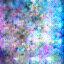

In [108]:
fake_image

In [109]:
real_image = Image.open("training_magician/darkmagician/23020408.jpg")
real_image = real_image.resize((64,64))

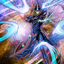

In [110]:
real_image

In [111]:
fake_array = numpy.array(fake_image)
real_array = numpy.array(real_image)

In [112]:
fake_array.shape == real_array.shape

True

In [122]:
lfake = numpy.array([fake_array, fake_array*0.5])
lreal = numpy.array([real_array, real_array*0.5])

In [123]:
images1 = lfake
images2= lreal
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

Scaled (2, 299, 299, 3) (2, 299, 299, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
FID (same): -0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
FID (different): 464.577


In [113]:
# example of calculating the frechet inception distance in Keras
import numpy
import os
os.environ["KERAS_BACKEND"] = "torch"
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
FID (same): -0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
FID (different): 40.022


In [75]:
import torch
import torchvision
import ignite

print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")


torch: 2.3.0
torchvision: 0.18.0
ignite: 0.5.0.post2


In [76]:
import os
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist


In [77]:
ignite.utils.manual_seed(999)


In [78]:
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)


<Logger ignite.distributed.launcher.Parallel (WARNING)>

In [79]:
from ignite.metrics import FID, InceptionScore

In [80]:
import ignite.distributed as idist

In [81]:
fid_metric = FID(device=idist.device())


In [82]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
torch.cuda.is_available()


True

In [83]:
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

# Acknowledgements

This wouldn't be possible without some good resources:

- Jovian.ml DCGAN example from PyTorch Zero to GANs Course: https://jovian.ml/aakashns/06b-anime-dcgan
- Tips and tricks about training GANs: https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9